# Task2: Handling text data (Text file)
load the dataset(https://drive.google.com/file/d/1gbz1gwag11jvAv_7EKxukU-zAbyASoMU/view?usp=sharing) and preprocess the text data, then create a classifier using sklearn and plot the results(Accuracy) to visualize the classifier's performance

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import re
import string
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

In [4]:
file_path = '/content/EmailDataset.txt'

In [8]:
f = open(file_path, "r")
print(f.read()[:150])

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
ham	Ok lar... Joking wif u oni...



In [11]:
# Read the text file and split into target and email components
targets = []
emails = []

with open(file_path, 'r') as file:
    for line in file:
        line = line.strip()
        target, email = line.split('\t', 1)
        targets.append(target)
        emails.append(email)

df = pd.DataFrame({'target': targets, 'email': emails})

In [12]:
df.head()

,target,email
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
df.shape

(5574, 2)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  5574 non-null   object
 1   email   5574 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [15]:
df.describe()

,target,email
count,5574,5574
unique,2,5160
top,ham,"Sorry, I'll call later"
freq,4827,30


In [16]:
df.isnull().sum()

target    0
email     0
dtype: int64

In [17]:
df.duplicated().sum()

414

In [18]:
df = df.drop_duplicates()

In [19]:
df.duplicated().sum()

0

In [21]:
df['target'].value_counts()

target
ham     4518
spam     642
Name: count, dtype: int64

**preprocessing**

In [28]:
df['email'] = df['email'].str.lower() #lower case
df['email'] = df['email'].replace(r'http\S+|www.\S+', '', regex=True) #remove links

In [29]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df["email"] = df["email"].apply(lambda text: remove_punctuation(text))
df.head()

,target,email
0,ham,go until jurong point crazy available only in ...
1,ham,ok lar joking wif u oni
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor u c already then say
4,ham,nah i dont think he goes to usf he lives aroun...


In [24]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    output= [i for i in text if i not in stopwords]
    return output

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [25]:
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [31]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df["email"] = df["email"].apply(lambda text: remove_stopwords(text))
df["email"]

0       go jurong point crazy available bugis n great ...
1                                 ok lar joking wif u oni
2       free entry 2 wkly comp win fa cup final tkts 2...
3                     u dun say early hor u c already say
4             nah dont think goes usf lives around though
                              ...                        
5569    2nd time tried 2 contact u u £750 pound prize ...
5570                          ü b going esplanade fr home
5571                          pity mood soany suggestions
5572    guy bitching acted like id interested buying s...
5573                                       rofl true name
Name: email, Length: 5160, dtype: object

In [32]:
df["email"] = df["email"].apply(lambda x: re.sub(r'\d+', '', str(x))) #remove numbers
df["email"]

0       go jurong point crazy available bugis n great ...
1                                 ok lar joking wif u oni
2       free entry  wkly comp win fa cup final tkts st...
3                     u dun say early hor u c already say
4             nah dont think goes usf lives around though
                              ...                        
5569    nd time tried  contact u u £ pound prize  clai...
5570                          ü b going esplanade fr home
5571                          pity mood soany suggestions
5572    guy bitching acted like id interested buying s...
5573                                       rofl true name
Name: email, Length: 5160, dtype: object

In [33]:
df["email"] = df["email"].apply(lambda x: re.sub(r'[^\x00-\x7F]', '', str(x))) #remove non-english word
df["email"]

0       go jurong point crazy available bugis n great ...
1                                 ok lar joking wif u oni
2       free entry  wkly comp win fa cup final tkts st...
3                     u dun say early hor u c already say
4             nah dont think goes usf lives around though
                              ...                        
5569    nd time tried  contact u u  pound prize  claim...
5570                            b going esplanade fr home
5571                          pity mood soany suggestions
5572    guy bitching acted like id interested buying s...
5573                                       rofl true name
Name: email, Length: 5160, dtype: object

In [34]:
def tokenization(text):
    tokens = re.split('W+',text)
    return tokens
df['email'] = df['email'].apply(lambda x: tokenization(x))
df['email']

0       [go jurong point crazy available bugis n great...
1                               [ok lar joking wif u oni]
2       [free entry  wkly comp win fa cup final tkts s...
3                   [u dun say early hor u c already say]
4           [nah dont think goes usf lives around though]
                              ...                        
5569    [nd time tried  contact u u  pound prize  clai...
5570                         [ b going esplanade fr home]
5571                        [pity mood soany suggestions]
5572    [guy bitching acted like id interested buying ...
5573                                     [rofl true name]
Name: email, Length: 5160, dtype: object

In [ ]:
nltk.download('punkt')
stemmer = PorterStemmer()
def apply_stemming(word_list):
    stem_words = [stemmer.stem(word) for word in word_list]
    return stem_words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df['email'] = df['email'].apply(apply_stemming)
df['email']

0       [go jurong point crazy available bugis n great...
1                               [ok lar joking wif u oni]
2       [free entry  wkly comp win fa cup final tkts s...
3                   [u dun say early hor u c already say]
4           [nah dont think goes usf lives around though]
                              ...                        
5569    [nd time tried  contact u u  pound prize  clai...
5570                          [ b going esplanade fr hom]
5571                            [pity mood soany suggest]
5572    [guy bitching acted like id interested buying ...
5573                                      [rofl true nam]
Name: Email, Length: 5160, dtype: object

**Word represntion**

In [35]:
x = df['email']
y = df['target']

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [38]:
X_train = [' '.join(x) for x in X_train]
X_test = [' '.join(x) for x in X_test]

In [39]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

In [40]:
vectorizer = TfidfVectorizer()
x_train_tfidf = vectorizer.fit_transform(X_train)
x_test_tfidf = vectorizer.transform(X_test)

In [42]:
NB_model = MultinomialNB()
NB_model.fit(x_train_tfidf, y_train)

MultinomialNB()

In [43]:
NB_y_pred_test = NB_model.predict(x_test_tfidf)
NB_y_pred_train = NB_model.predict(x_train_tfidf)

In [44]:
accuracy_NB_train = accuracy_score(y_train, NB_y_pred_train)
accuracy_NB_test = accuracy_score(y_test, NB_y_pred_test)
accuracy_NB_test

0.9602713178294574

In [47]:
report_nv = classification_report(y_test, NB_y_pred_test)
print("Classification Report:")
print(report_nv)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       916
           1       1.00      0.65      0.79       116

    accuracy                           0.96      1032
   macro avg       0.98      0.82      0.88      1032
weighted avg       0.96      0.96      0.96      1032



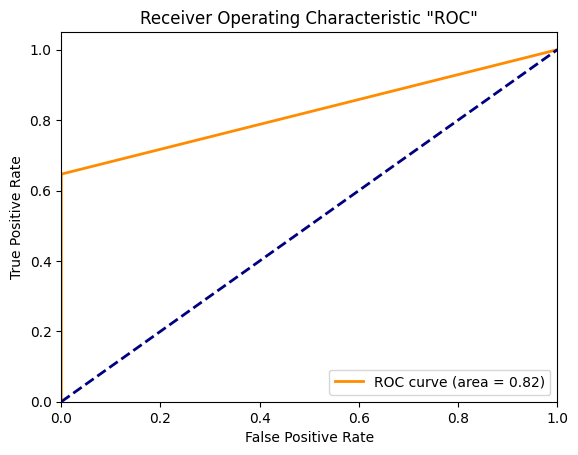

In [48]:
fpr, tpr, thresholds = roc_curve(y_test, NB_y_pred_test)
roc_auc = auc(fpr, tpr)

precision, recall, thresholds_pr = precision_recall_curve(y_test, NB_y_pred_test)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic "ROC"')
plt.legend(loc="lower right")
plt.show()

In [49]:
import joblib
joblib.dump(NB_model, "NB_model.joblib")

['NB_model.joblib']